<a href="https://colab.research.google.com/github/Pariasjulian/IA/blob/main/P_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Conv2DTranspose, Reshape, BatchNormalization, Dropout
from keras.metrics import categorical_accuracy
from tensorflow.keras.losses import Loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from tensorflow.keras import layers, regularizers

# Dataset

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Functions

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Class

In [ ]:
class ScaledBinaryCrossentropy:
    def __init__(self, scale=1.0):
        """
        Inicializa la clase de pérdida personalizada.
        :param scale: float, el factor de escala para la pérdida.
        :param name: str, nombre de la pérdida.
        """

        self.scale = scale

    def __call__(self, y_true, y_pred):
        """
        Calcula la pérdida escalada.
        :param y_true: Tensor, etiquetas verdaderas.
        :param y_pred: Tensor, predicciones del modelo.
        :return: Tensor, pérdida escalada.
        """
        # Calcula la binary crossentropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Retorna la binary crossentropy escalada
        return self.scale * bce

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, alpha=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = self.alpha * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Regularized Autoencoder

In [ ]:
# Set random seed for reproducibility in TensorFlow and NumPy
tf.random.set_seed(42)
np.random.seed(42)

# Define the encoder part of the autoencoder
regularized_encoder = keras.models.Sequential([
    # Reshape the input data from [28, 28] to [28, 28, 1] to match the expected input shape for Conv2D layers.
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),

    # First convolutional layer: 32 filters, 3x3 kernel size, 'same' padding, 'selu' activation function,
    # and L1 regularization with a factor of 0.001 to help prevent overfitting.
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),

    # Max pooling layer with a pool size of 2x2 to downsample the feature maps.
    keras.layers.MaxPooling2D(pool_size=2),

    # Second convolutional layer: 64 filters, 3x3 kernel size, 'same' padding, 'selu' activation function,
    # and L1 regularization.
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),

    # Another max pooling layer to further downsample the feature maps.
    keras.layers.MaxPooling2D(pool_size=2),

    # Third convolutional layer: 128 filters, 3x3 kernel size, 'same' padding, 'selu' activation function,
    # and L1 regularization.
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),

    # Flatten the output of the convolutional layers to prepare it for the dense layer.
    keras.layers.Flatten(),

    # Dense layer with 400 units and 'selu' activation function to learn complex features.
    keras.layers.Dense(400, activation="selu")
])

# Define the decoder part of the autoencoder
regularized_decoder = keras.models.Sequential([
    # Dense layer to project the input from the latent space to a higher-dimensional space suitable for reshaping.
    keras.layers.Dense(7 * 7 * 128, activation="selu", input_shape=[400]),

    # Reshape the output from the dense layer to match the dimensions needed for the Conv2DTranspose layers.
    keras.layers.Reshape([7, 7, 128]),

    # First transposed convolutional layer (deconvolution) to upsample the feature maps, with 64 filters, 3x3 kernel size,
    # strides of 2 for upsampling, 'selu' activation function, and L1 regularization.
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),

    # Second transposed convolutional layer to further upsample the feature maps, with 32 filters, 3x3 kernel size,
    # 'selu' activation function, and L1 regularization.
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),

    # Final convolutional layer to produce the output image with 1 channel (grayscale) and 'sigmoid' activation function
    # to map pixel values in [0, 1]. This layer uses 'same' padding to ensure the output size matches the input size.
    keras.layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid", kernel_regularizer=regularizers.l1(0.001)),

    # Reshape the output to match the original image dimensions [28, 28].
    keras.layers.Reshape([28, 28])
])

# Combine the encoder and decoder into a single autoencoder model
regularized_ae = keras.models.Sequential([regularized_encoder, regularized_decoder])

# Compile the autoencoder model with binary crossentropy loss, Adam optimizer with a learning rate of 1e-3,
# and a custom metric called 'rounded_accuracy'.
regularized_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[rounded_accuracy])

# Train the autoencoder model with training data (X_train) and validation data (X_valid) for 100 epochs with a batch size of 64.
history = regularized_ae.fit(X_train, X_train, epochs=80, batch_size=32,
                         validation_data=(X_valid, X_valid))


Epoch 1/100
860/860 [==============================] - 11s 10ms/step - loss: 0.5349 - rounded_accuracy: 0.9091 - val_loss: 0.3386 - val_rounded_accuracy: 0.9178
Epoch 2/100
860/860 [==============================] - 8s 9ms/step - loss: 0.3288 - rounded_accuracy: 0.9258 - val_loss: 0.3259 - val_rounded_accuracy: 0.9291
Epoch 3/100
860/860 [==============================] - 8s 10ms/step - loss: 0.3223 - rounded_accuracy: 0.9305 - val_loss: 0.3221 - val_rounded_accuracy: 0.9315
Epoch 4/100
860/860 [==============================] - 9s 10ms/step - loss: 0.3195 - rounded_accuracy: 0.9329 - val_loss: 0.3201 - val_rounded_accuracy: 0.9335
Epoch 5/100
860/860 [==============================] - 8s 9ms/step - loss: 0.3176 - rounded_accuracy: 0.9346 - val_loss: 0.3183 - val_rounded_accuracy: 0.9359
Epoch 6/100
860/860 [==============================] - 8s 10ms/step - loss: 0.3161 - rounded_accuracy: 0.9360 - val_loss: 0.3171 - val_rounded_accuracy: 0.9358
Epoch 7/100
860/860 [====================

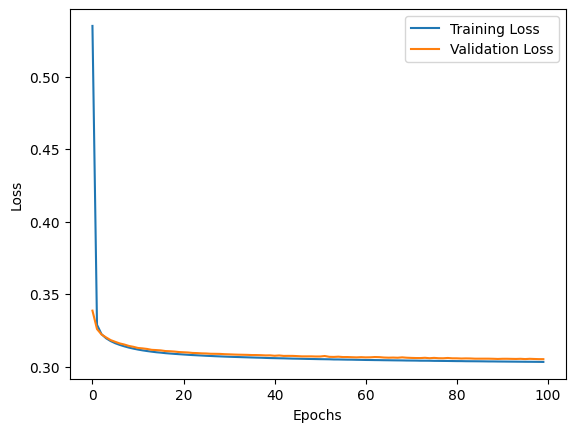

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

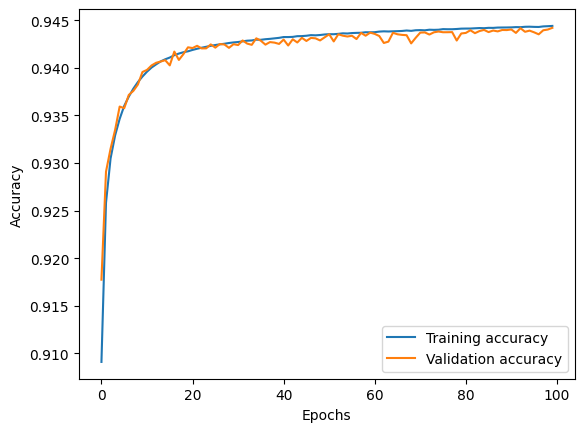

In [ ]:
plt.plot(history.history['rounded_accuracy'], label='Training accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 296ms/step


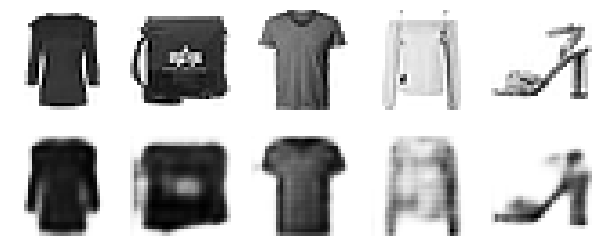

In [ ]:
show_reconstructions(regularized_ae)
plt.show()

# VAE

In [ ]:
def build_encoder(latent_dim):
    # Define the input layer with a shape corresponding to the image size (28x28) and 1 channel (grayscale).
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))

    # First convolutional layer: 32 filters, kernel size 3x3, 'selu' activation function, stride of 2 for downsampling, and 'same' padding.
    x = tf.keras.layers.Conv2D(32, 3, activation='selu', strides=2, padding='same')(encoder_inputs)

    # Batch normalization applied to stabilize and accelerate training.
    x = BatchNormalization()(x)

    # Second convolutional layer: 64 filters, kernel size 3x3, 'selu' activation function, stride of 2 for further downsampling, and 'same' padding.
    x = tf.keras.layers.Conv2D(64, 3, activation='selu', strides=2, padding='same')(x)

    # Batch normalization again to stabilize the network.
    x = BatchNormalization()(x)

    # Flatten the output from the convolutional layers to prepare it for the dense layers.
    x = tf.keras.layers.Flatten()(x)

    # Dense layer with 128 units and 'selu' activation function for learning complex representations.
    x = tf.keras.layers.Dense(128, activation='selu')(x)

    # Dropout layer with a rate of 0.3 to prevent overfitting by randomly setting 30% of the inputs to zero during training.
    x = Dropout(0.3)(x)

    # Dense layer to produce the mean of the latent space distribution.
    z_mean = tf.keras.layers.Dense(latent_dim)(x)

    # Dense layer to produce the log variance of the latent space distribution.
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)

    # Define the encoder model that outputs the mean and log variance of the latent space.
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

    return encoder

def build_decoder(latent_dim):
    # Define the input layer with shape corresponding to the latent space dimension.
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # Dense layer to project the latent space representation to a higher-dimensional space.
    x = tf.keras.layers.Dense(7*7*64, activation='selu')(decoder_inputs)

    # Reshape the output of the dense layer to match the dimensions required for the convolutional layers.
    x = tf.keras.layers.Reshape((7, 7, 64))(x)

    # First transposed convolutional layer (deconvolution) to upsample the feature maps, with 64 filters, kernel size 3x3, 'selu' activation, and stride of 2.
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='selu', strides=2, padding='same')(x)

    # Batch normalization applied to stabilize and accelerate training.
    x = BatchNormalization()(x)

    # Second transposed convolutional layer to further upsample the feature maps, with 32 filters, kernel size 3x3, 'selu' activation, and stride of 2.
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='selu', strides=2, padding='same')(x)

    # Batch normalization again to stabilize the network.
    x = BatchNormalization()(x)

    # Final transposed convolutional layer to produce the output image with 1 channel (grayscale) and 'sigmoid' activation function for pixel values in [0, 1].
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    # Define the decoder model that outputs the reconstructed image.
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')

    return decoder


In [ ]:
latent_dim = 256
alpha = 0.2
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

vae = VAE(encoder, decoder, alpha=alpha)
beta= 1-alpha
loss_=ScaledBinaryCrossentropy(beta)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss_,metrics=[rounded_accuracy])
history = vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/100
1719/1719 [==============================] - 18s 8ms/step - loss: 0.3344 - rounded_accuracy: 0.8645 - val_loss: 0.3023 - val_rounded_accuracy: 0.8793
Epoch 2/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2920 - rounded_accuracy: 0.8867 - val_loss: 0.2795 - val_rounded_accuracy: 0.8965
Epoch 3/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2812 - rounded_accuracy: 0.8931 - val_loss: 0.2712 - val_rounded_accuracy: 0.9007
Epoch 4/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2753 - rounded_accuracy: 0.8965 - val_loss: 0.2667 - val_rounded_accuracy: 0.9030
Epoch 5/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2719 - rounded_accuracy: 0.8991 - val_loss: 0.2670 - val_rounded_accuracy: 0.9011
Epoch 6/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2696 - rounded_accuracy: 0.9007 - val_loss: 0.2653 - val_rounded_accuracy: 0.9005
Epoch 7/100
1719/1719 [=====

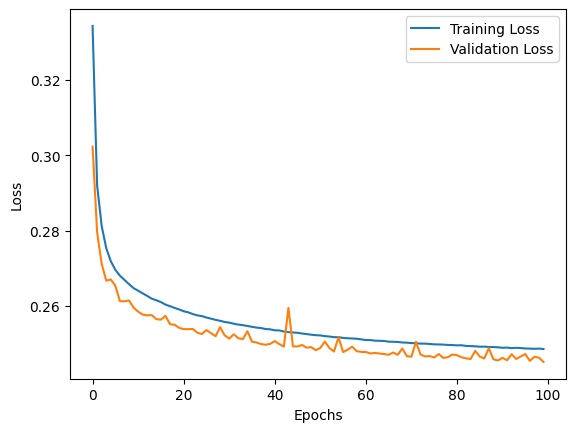

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

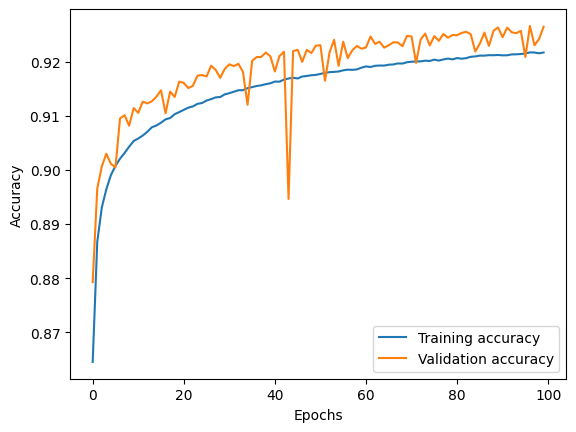

In [ ]:
plt.plot(history.history['rounded_accuracy'], label='Training accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 294ms/step


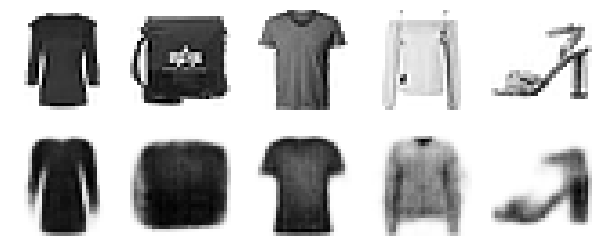

In [ ]:
show_reconstructions(vae)
plt.show()